In [89]:
import os
import pandas as pd
import time
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

data_dir_1 = '/workspaces/Final-Year-Project/Data/2023/'
file_list = os.listdir(data_dir_1)
sas_files = [file for file in file_list if file.endswith('.XPT') or file.endswith('.xpt')]

first_file_path = os.path.join(data_dir_1, sas_files[0])
merged_df = pd.read_sas(first_file_path, format='xport', encoding='iso-8859-1')

for file_name in sas_files[1:]:
    file_path = os.path.join(data_dir_1, file_name)
    df = pd.read_sas(file_path, format='xport', encoding='iso-8859-1')
    if 'SEQN' not in df.columns:
        continue  # Skip files missing SEQN
    merged_df = pd.merge(merged_df, df, on='SEQN', how='outer', suffixes=('', f'_{file_name}'))
    del df  # Free memory

merged_df = merged_df.select_dtypes(include=['float64'])

#save to csv
merged_df.to_csv('/workspaces/Final-Year-Project/Cleaned Data/ImpAllMergedData.csv', index=False)

In [90]:
# Categorize Diabetes Status
def categorize_diabetes(row):    
    if (pd.notnull(row['LBXGH']) and row['LBXGH'] >= 5.7) or (pd.notnull(row['LBXGLU']) and row['LBXGLU'] >= 100):
        return 1  # Diabetes / At Risk
    else:
        return 0  # No Diabetes

merged_df['Diabetes Status'] = merged_df.apply(categorize_diabetes, axis=1)
merged_df.drop(columns=['LBXGH', 'LBXGLU', 'LBDGLUSI'], inplace=True)

# Remove 10% of data for REAL validation (no imputations)
df_train_test, df_validate = train_test_split(merged_df, test_size=0.1, random_state=42)

# Save REAL validation data before imputation
df_validate.to_csv("/workspaces/Final-Year-Project/Cleaned Data/ImpValidationData.csv", index=False)

df_train_test['Diabetes Status'].value_counts()

Diabetes Status
0    7817
1    2922
Name: count, dtype: int64

In [91]:
# Separate `Diabetes Status` before handling missing values
diabetes_status = df_train_test['Diabetes Status']
df_train_test = df_train_test.drop(columns=['Diabetes Status'])

# Remove rows where any column contains the value `9` (Unknown)
df_train_test = df_train_test[~(df_train_test == 9).any(axis=1)]

# Impute missing values with column means
df_train_test = df_train_test.fillna(df_train_test.mean())

# Reattach `Diabetes Status`
df_train_test['Diabetes Status'] = diabetes_status.loc[df_train_test.index]  # Ensure alignment

# Balance dataset (Downsample larger class)
no_diabetes = df_train_test[df_train_test['Diabetes Status'] == 0]
diabetes = df_train_test[df_train_test['Diabetes Status'] == 1]

# Get the minority class size
minority_class_size = min(len(no_diabetes), len(diabetes))

# Ensure resampling is valid
if minority_class_size > 0:
    no_diabetes_downsampled = resample(no_diabetes, replace=False, n_samples=minority_class_size, random_state=42)
    diabetes_downsampled = resample(diabetes, replace=False, n_samples=minority_class_size, random_state=42)

    # Merge and shuffle the balanced dataset
    df_balanced = pd.concat([no_diabetes_downsampled, diabetes_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    print("⚠️ Warning: One of the classes has no samples after filtering! Keeping original dataset.")
    df_balanced = df_train_test

# Save cleaned & balanced training/testing data
df_balanced.to_csv("/workspaces/Final-Year-Project/Cleaned Data/ImpTrainTestData.csv", index=False)

# Print class distribution after balancing
print("Balanced Diabetes Status Distribution:\n", df_balanced['Diabetes Status'].value_counts())

# Show dataset info
df_balanced.info()


/tmp/ipykernel_3041/462211732.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_test['Diabetes Status'] = diabetes_status.loc[df_train_test.index]  # Ensure alignment


Balanced Diabetes Status Distribution:
 Diabetes Status
0    858
1    858
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716 entries, 0 to 1715
Columns: 314 entries, SEQN to Diabetes Status
dtypes: float64(313), int64(1)
memory usage: 4.1 MB


In [92]:
df_corr = df_balanced.corr()

df_top_filtered = df_corr['Diabetes Status'].abs()[df_corr['Diabetes Status'].abs() > 0.30]

columns_to_keep = df_top_filtered.index
df_filtered = df_balanced[columns_to_keep]

Text(0.5, 1.0, 'Correlation Matrix')

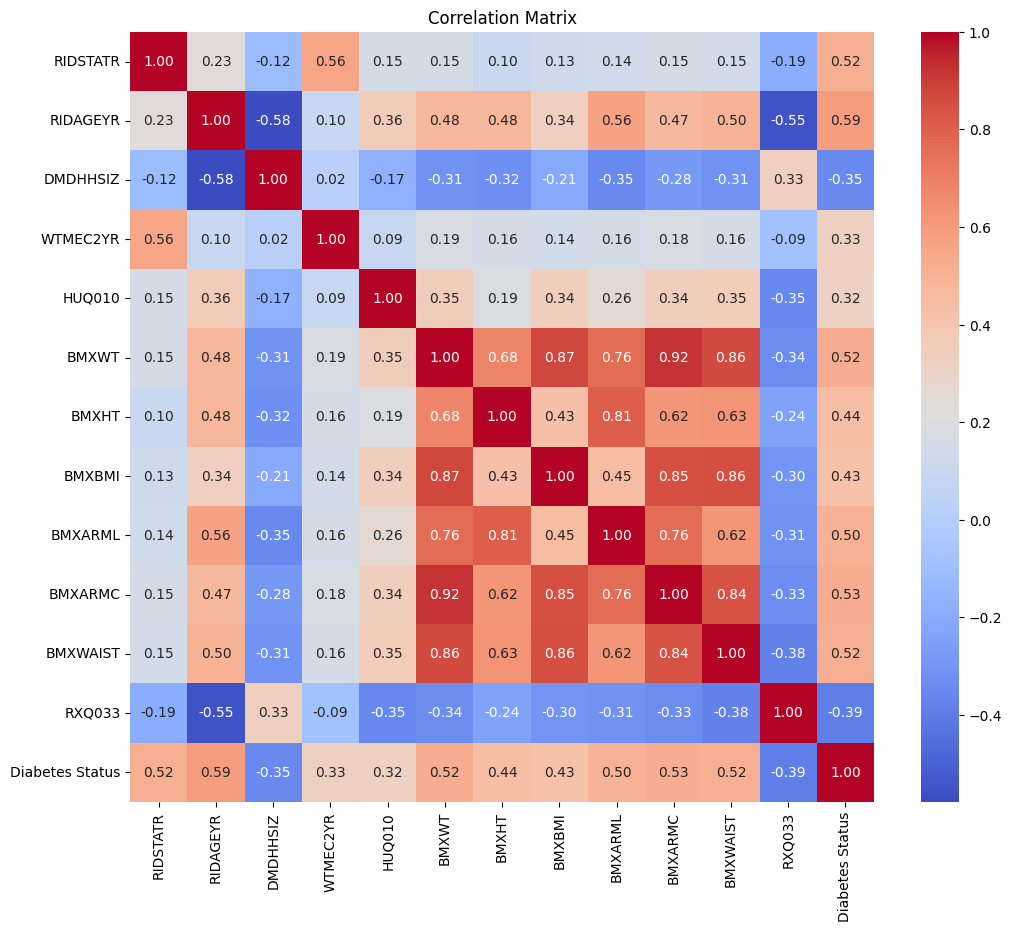

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix')

In [111]:
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

df = df_filtered

X = df.drop('Diabetes Status', axis=1)
y = df['Diabetes Status']

scaler = StandardScaler()
X = scaler.fit_transform(X)

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [17],  
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=kf, n_jobs=-1, verbose=1)

grid_search.fit(X, y)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X)

print("Best Parameters for KNN:", grid_search.best_params_)
print("Mean Accuracy with Best Parameters:", grid_search.best_score_)

print("KNN Classification Report:")
print(classification_report(y, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters for KNN: {'n_neighbors': 17}
Mean Accuracy with Best Parameters: 0.8694555563089024
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       858
           1       0.83      0.97      0.89       858

    accuracy                           0.88      1716
   macro avg       0.89      0.88      0.88      1716
weighted avg       0.89      0.88      0.88      1716

Confusion Matrix:
[[683 175]
 [ 29 829]]


In [112]:
# Load validation dataset
df_validate = pd.read_csv("/workspaces/Final-Year-Project/Cleaned Data/ImpValidationData.csv")

# Select the same high-correlation columns used in training
selected_features = df_filtered.columns.drop('Diabetes Status')  # Keep same feature set
df_validate = df_validate[selected_features]

df_validate = df_validate.dropna()

# Extract target variable
X_valid = df_validate
y_valid = pd.read_csv("/workspaces/Final-Year-Project/Cleaned Data/ImpValidationData.csv")['Diabetes Status'].loc[df_validate.index]  # Ensure alignment

# Scale validation data using the same scaler from training
X_valid_scaled = scaler.transform(X_valid)

# Predict using trained model
y_pred_valid = best_knn.predict(X_valid_scaled)

# Print classification report
print(f"📌 KNN - Validation Classification Report:")
print(classification_report(y_valid, y_pred_valid))

# Print confusion matrix
print("🟦 KNN - Validation Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_valid))


📌 KNN - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.52      0.66       495
           1       0.55      0.94      0.69       307

    accuracy                           0.68       802
   macro avg       0.74      0.73      0.68       802
weighted avg       0.78      0.68      0.67       802

🟦 KNN - Validation Confusion Matrix:
[[256 239]
 [ 19 288]]
